In [28]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, utils, datasets
from collections import Counter
import re

class ImageFolderExclude(datasets.ImageFolder):
    def __init__(self, root, exclude_pattern=None, **kwargs):
        self.exclude_pattern = re.compile(exclude_pattern) if exclude_pattern else None
        super().__init__(root, **kwargs)

    def find_classes(self, directory):
        classes = [entry.name for entry in os.scandir(directory) if entry.is_dir()]
        if self.exclude_pattern:
            classes = [cls for cls in classes if self.exclude_pattern.fullmatch(cls)]
        classes.sort()
        class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
        return classes, class_to_idx

class KaakaaDataset(Dataset):
    def __init__(self, root_dir, csv_file=None, prune=True, transform=None):
        self.class_counts = Counter()
        self.root_dir = root_dir
        self.csv_file = csv_file #if I ever use the Cornell dataset...
        self.transform = transform
        
        if prune:
            pattern = r'^[A-WYZa-wyz]{1,2}-[A-WYZa-wyz]{1,2}$'
            self.dataset = ImageFolderExclude(root=self.root_dir, exclude_pattern=pattern, transform=self.transform)
        else: 
            self.dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        
        all_datasets = self.dataset.datasets if isinstance(self.dataset, ConcatDataset) else [self.dataset]
        #counting up what we have for each class
        for ds in all_datasets:
            for _, label in ds.samples:
                self.class_counts[ds.classes[label]] += 1
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return {"image": image, "label": label}

In [29]:
def show_kaakaa(image, label):
    """Show image"""
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0) #(C, H, W) -> (H, W, C)
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

Counter({'MO-R': 355, 'LM-G': 193, 'O-LW': 163, 'K-WP': 154, 'Y-GL': 140, 'PR-K': 58, 'L-MB': 56, 'L-YM': 40, 'YM-Y': 36, 'MR-L': 17, 'W-BB': 17, 'BR-L': 2})
['BR-L', 'K-WP', 'L-MB', 'L-YM', 'LM-G', 'MO-R', 'MR-L', 'O-LW', 'PR-K', 'W-BB', 'Y-GL', 'YM-Y']
0
0 torch.Size([3, 540, 768]) 0


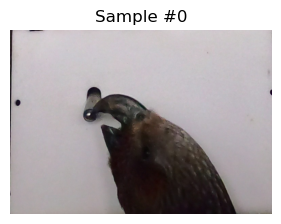

1
1 torch.Size([3, 540, 768]) 0


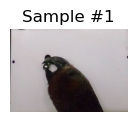

2
2 torch.Size([3, 540, 768]) 1


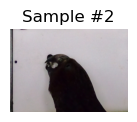

3
3 torch.Size([3, 540, 768]) 1


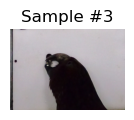

In [31]:
from dotenv import load_dotenv

load_dotenv()

transform = transforms.Compose([
    transforms.ToTensor() #so we can call plt on our image
])

dataset_a = KaakaaDataset(root_dir=os.getenv("DATASET_A"), prune=True, transform=transform);
dataset_b = KaakaaDataset(root_dir=os.getenv("DATASET_B"), prune=True, transform=transform);
dataset_c = KaakaaDataset(root_dir=os.getenv("DATASET_C"), prune=True, transform=transform);

In [ ]:
print(dataset_a.class_counts)
print(dataset_a.dataset.classes)


fig = plt.figure(figsize=(12, 8))

for i, sample in enumerate(dataset_a):
    print(i)
    print(i, sample['image'].shape, sample['label'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_kaakaa(**sample)

    if i == 3:
        plt.show()
        break